# COGS 118B Final Project

## Pre-Reqs

In [1]:
# required imports

import random
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import islice
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# do not show warning for division by 0
_ = np.seterr(divide='ignore', invalid='ignore')

## Exploring the Data

In [2]:
# import dataset and display it

data = pd.read_csv('data.csv', encoding='cp1252').drop('Index', axis=1)
original_size = len(data)

data

,Title,Artist,Top Genre,Year,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Length (Duration),Acousticness,Speechiness,Popularity
0,Sunrise,Norah Jones,adult standards,2004,157,30,53,-14,11,68,201,94,3,71
1,Black Night,Deep Purple,album rock,2000,135,79,50,-11,17,81,207,17,7,39
2,Clint Eastwood,Gorillaz,alternative hip hop,2001,168,69,66,-9,7,52,341,2,17,69
3,The Pretender,Foo Fighters,alternative metal,2007,173,96,43,-4,3,37,269,0,4,76
4,Waitin' On A Sunny Day,Bruce Springsteen,classic rock,2002,106,82,58,-5,10,87,256,1,3,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,Heartbreak Hotel,Elvis Presley,adult standards,1958,94,21,70,-12,11,72,128,84,7,63
1990,Hound Dog,Elvis Presley,adult standards,1958,175,76,36,-8,76,95,136,73,6,69
1991,Johnny B. Goode,Chuck Berry,blues rock,1959,168,80,53,-9,31,97,162,74,7,74
1992,Take Five,The Dave Brubeck Quartet,bebop,1959,174,26,45,-13,7,60,324,54,4,65


In [3]:
# check for missing data

print(f'There are {data.isnull().sum().sum()} missing values.')

There are 0 missing values.


The following features from the dataset will be used for clustering:

1 - Beats Per Minute (BPM)
2 - Energy
3 - Danceability
4 - Loudness (dB)
5 - Liveness
6 - Valence
7 - Acousticness
8 - Speechiness


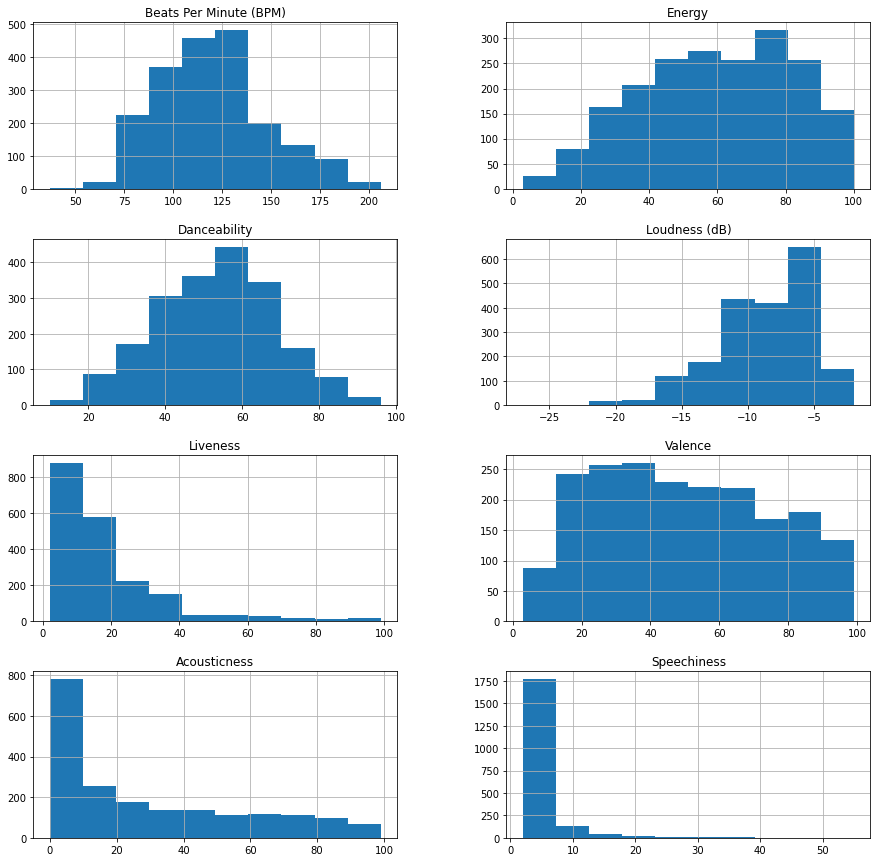

In [4]:
# extract audio features relevant to clustering and display them with their distribution

features = list(data.columns[4:13])
del features[6]

print('The following features from the dataset will be used for clustering:\n')

for i, feature in enumerate(features):
    print(f'{i + 1} - {feature}')
    
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
fig = data.hist(column=features, ax=axes)

In [5]:
# extract the genres and display them

def get_genres():
    return sorted(data['Top Genre'].unique(), reverse = True, 
                  key = lambda genre: len(data.loc[data['Top Genre'] == genre]))

def display_genres():
    genres = get_genres()
    
    print(f'Displaying {len(genres)} genres.\n')
    
    longest_length = len(max(genres, key = len))
    
    print(f'{"idx":{3}} | {"genres":^{longest_length}} | {"# entries":^{3}}\n' + '-' * (longest_length + 18))
    
    for i, genre in enumerate(genres):
        num = len(data.loc[data['Top Genre'] == genre])
        print(f'{i + 1:<{3}} | {genre:{longest_length}} | {num:<{9}}')
    
display_genres()

Displaying 149 genres.

idx |           genres            | # entries
---------------------------------------------
1   | album rock                  | 413      
2   | adult standards             | 123      
3   | dutch pop                   | 88       
4   | alternative rock            | 86       
5   | dance pop                   | 83       
6   | dutch indie                 | 75       
7   | alternative metal           | 70       
8   | dance rock                  | 52       
9   | classic rock                | 51       
10  | dutch cabaret               | 51       
11  | modern rock                 | 49       
12  | glam rock                   | 49       
13  | pop                         | 47       
14  | art rock                    | 40       
15  | permanent wave              | 38       
16  | british invasion            | 36       
17  | irish rock                  | 34       
18  | british soul                | 31       
19  | europop                     | 27       
20  | clas

## Preparing the Data

In [6]:
# 149 genres leads to too many clusters. we reduce this number in two ways:
# 1: group similar genres together (ie: 'album rock' and 'alternative rock' are grouped under 'rock')
# 2: only pick the most represented genres in the dataset

# 1
def group_genres(groups):
    for group in groups:
        data.loc[[group in genre for genre in data['Top Genre']], 'Top Genre'] = group

group_genres(['rock', 'pop', 'indie', 'hip hop', 'soul', 'metal', 'country', 'folk', 'jazz', 'elec', 'dance'])

# 2 (only keep genres with more than 20 songs)
top_genres = [genre for genre in get_genres() if len(data.loc[data['Top Genre'] == genre]) > 20]
data = data[data['Top Genre'].isin(top_genres)]

display_genres()

print(f'\nThe dataset now has {len(data)} entries.\n{original_size - len(data)} entries were removed, ' +
       'keeping only songs that belong in a genre with 10 or more songs. ')

data

Displaying 10 genres.

idx |      genres      | # entries
----------------------------------
1   | rock             | 857      
2   | pop              | 388      
3   | adult standards  | 123      
4   | metal            | 93       
5   | indie            | 79       
6   | dutch cabaret    | 51       
7   | soul             | 45       
8   | permanent wave   | 38       
9   | british invasion | 36       
10  | hip hop          | 29       

The dataset now has 1739 entries.
255 entries were removed, keeping only songs that belong in a genre with 10 or more songs. 


,Title,Artist,Top Genre,Year,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Length (Duration),Acousticness,Speechiness,Popularity
0,Sunrise,Norah Jones,adult standards,2004,157,30,53,-14,11,68,201,94,3,71
1,Black Night,Deep Purple,rock,2000,135,79,50,-11,17,81,207,17,7,39
2,Clint Eastwood,Gorillaz,hip hop,2001,168,69,66,-9,7,52,341,2,17,69
3,The Pretender,Foo Fighters,metal,2007,173,96,43,-4,3,37,269,0,4,76
4,Waitin' On A Sunny Day,Bruce Springsteen,rock,2002,106,82,58,-5,10,87,256,1,3,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1988,Summertime,Louis Armstrong,adult standards,1958,168,7,17,-21,14,10,298,92,3,66
1989,Heartbreak Hotel,Elvis Presley,adult standards,1958,94,21,70,-12,11,72,128,84,7,63
1990,Hound Dog,Elvis Presley,adult standards,1958,175,76,36,-8,76,95,136,73,6,69
1991,Johnny B. Goode,Chuck Berry,rock,1959,168,80,53,-9,31,97,162,74,7,74


## K - Means (Pre-PCA)

In [7]:
# methods to run k-means and display the results (inspired by hw2)

def k_means(k, feats):
    final_rnk = None
    prev_centroids = None

    centroids_idxs = [random.randrange(0, len(feats), 1) for i in range(k)]
    centroids = np.array([f for i, f in enumerate(feats) if i in centroids_idxs])
    
    while True:
        dist_mat = cdist(feats, centroids)
        rnk = np.array([np.amin(dist_mat, axis = 1)] * len(dist_mat[0])).T == dist_mat

        prev_centroids = centroids
        centroids = (np.matmul(feats.T, rnk).T / 
                     np.array([np.sum(rnk, axis = 0)] * len(feats[0])).T)
                
        if abs(np.nansum(centroids - prev_centroids)) < 1e-6:
            final_rnk = rnk
            break
    
    c_d = {i: [] for i in range (k)}
    c_d_l = []

    for i, c in enumerate(final_rnk.T):
        c_d[i] = np.nonzero(c)

    for k in c_d:
        c_d_l.append([data.iloc[i] for i in c_d[k]][0])
    
    return (np.sort([np.count_nonzero(np.argmax(final_rnk, axis = 1) == i) for i in range(k)])[::-1], 
            sorted(c_d_l, key=len, reverse=True))


def print_cluster_counts():
    print(f'{len(data[features].values.tolist())} data points were clustered as such:\n\n' + 
          f'{"cluster id"} | {"# in cluster"} \n' + '-' * (25))
    
    for i, c in enumerate(cluster_counts):
        print(f'{i + 1:^10} | {c:^14}')

In [8]:
cluster_counts, _ = k_means(np.array(len(top_genres)), np.array(data[features].values.tolist()))
print_cluster_counts()

1739 data points were clustered as such:

cluster id | # in cluster 
-------------------------
    1      |      240      
    2      |      228      
    3      |      217      
    4      |      185      
    5      |      172      
    6      |      172      
    7      |      156      
    8      |      145      
    9      |      137      


## Principal Component Analysis

In [9]:
# declare characteristics matrix

c_matrix = data[features].to_numpy().transpose()

In [10]:
# eigensort from hw4

# [Vsort,Dsort] = eigsort(V, eigvals)
#
# Sorts a matrix eigenvectors and a array of eigenvalues in order 
# of eigenvalue size, largest eigenvalue first and smallest eigenvalue
# last.
#
# Example usage:
# di, V = np.linarg.eig(L)
# Vnew, Dnew = eigsort(V, di)
#
# Tim Marks 2002
def eigsort(V, eigvals):
    
    # Sort the eigenvalues from largest to smallest. Store the sorted
    # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)
    
    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted
    # eigenvectors as columns of the matrix vsort.
    M = np.size(lambd)
    Vsort = np.zeros((M, M))
    
    for i in range(M):
        Vsort[:,i] = V[:,index[i]]
        
    return Vsort, Dsort

In [11]:
# method to run pca

def pca(data_matrix, characteristics):
    c_matrix = data_matrix
    mean_c = np.mean(c_matrix, axis=1, keepdims=True)
    c_standardized=c_matrix-mean_c
    cov_matrix=np.matmul(c_standardized, c_standardized.transpose())/7
    dold, vold = np.linalg.eig(cov_matrix)
    v, d = eigsort(vold, dold)
    new_c_matrix = np.matmul(v[:,0:3].transpose(), c_standardized)
    
    return new_c_matrix, v, d

Below is the heat map obtained from PCA.



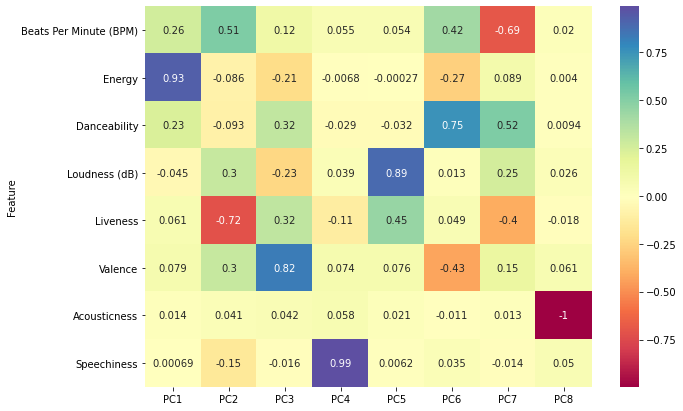

In [12]:
new_c_matrix, v, d = pca(c_matrix, features)
num_pc = 8
pc_list = ['PC'+str(i) for i in list(range(1, num_pc+1))]
v_df = pd.DataFrame.from_dict(dict(zip(pc_list, v)))
v_df['Feature'] = features
v_df = v_df.set_index('Feature')

print('Below is the heat map obtained from PCA.\n')

plt.figure(figsize=(10, 7))
_ = sns.heatmap(v_df, annot=True, cmap='Spectral')
plt.show()

Below is the scree plot obtained from PCA.
The top 3 components make up for 0.81% of the variability.



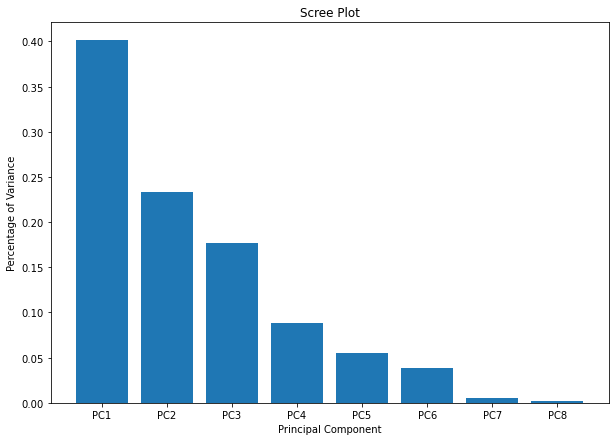

In [13]:
index_values = np.arange(8)+1
normalized_variability = d.diagonal()/sum(d.diagonal())

plt.figure(figsize=(10, 7))
plt.bar(index_values,normalized_variability)
plt.title('Scree Plot');
plt.xlabel('Principal Component');
plt.ylabel('Percentage of Variance');
plt.xticks(index_values, pc_list);

print(f'Below is the scree plot obtained from PCA.\nThe top 3 components make up for ' + 
      f'{normalized_variability[0]+normalized_variability[1]+normalized_variability[2]:.2f}% of the variability.\n')

From the Scree plot we can see that the first 3 components have the largest effect on the variability of the data, so we should focus on using those for further analysis. They make up 81.1%, which is above the recommended 80% threshold.

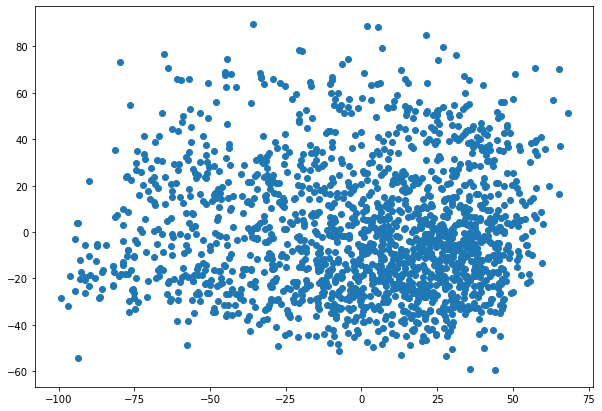

In [14]:
plt.figure(figsize=(10, 7))
plt.scatter(new_c_matrix[0], new_c_matrix[1]);

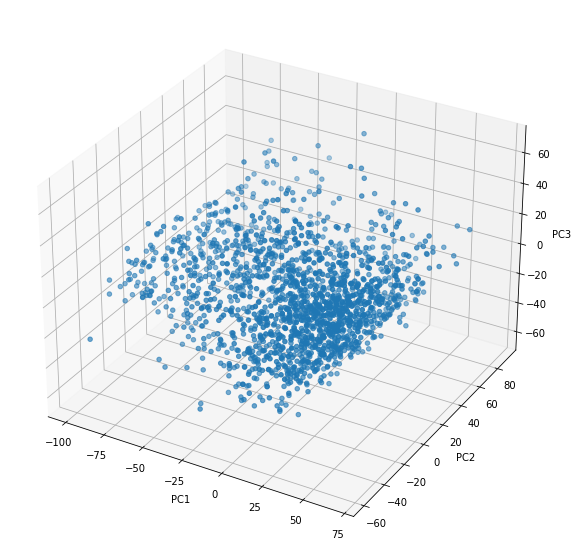

In [15]:
fig = plt.figure(figsize=(10,10));
axes = fig.add_subplot(projection='3d');
axes.scatter(new_c_matrix[0], new_c_matrix[1], new_c_matrix[2]);
axes.set_xlabel('PC1');
axes.set_ylabel('PC2');
axes.set_zlabel('PC3');

In [16]:
# find which features contribute the most

top_3_pcs = list(v_df.columns[:3])

imp_coeffs = {f: 0 for f in features}

for i, pc_col in enumerate(top_3_pcs):
    for idx in v_df.index:
        imp_coeffs[idx] += abs(v_df[pc_col][idx] * normalized_variability[i])
        
top_3_feats = list(dict(sorted(imp_coeffs.items(), reverse = True, key = lambda item: item[1])).keys())[:3]

print(f'The 3 features that contribute the most to clustering are {top_3_feats[0]}, {top_3_feats[1]}, and {top_3_feats[2]}.')

The 3 features that contribute the most to clustering are Energy, Liveness, and Valence.


## K - Means (Post-PCA)

In [17]:
cluster_counts, clustered_data = k_means(np.array(len(top_genres)), np.array(data[top_3_feats].values.tolist()))
print_cluster_counts()

1739 data points were clustered as such:

cluster id | # in cluster 
-------------------------
    1      |      244      
    2      |      231      
    3      |      228      
    4      |      226      
    5      |      207      
    6      |      207      
    7      |      190      
    8      |      113      
    9      |       59      


## Finding Artists' Genres

In [18]:
# making a new dataframe with Artist and Top Genres
ag_df = data[['Artist', 'Top Genre']]

# making a dictionary with all artists as a key and an empty array as the value
ag_dict = {k: [] for k in ag_df['Artist'].unique()}

# iterating through each row and adding genres as a value for the respective artist
for row in ag_df.iterrows():
    ag_dict[row[1]['Artist']].append(row[1]['Top Genre'])

# removing all duplicate values 
for k in ag_dict:
    ag_dict[k] = list(set(ag_dict[k]))

# display genres for each artist
ag_dict = {p[0]: p[1] for p in sorted(ag_dict.items(), key=lambda kv: len(kv[0]), reverse=True)}

print(f'There are {len(ag_dict)} artists in the dataset. ' +
      f'Each artist only fits into {max(len(r) for r in list(ag_dict.values()))} genre.\n\n')

#print(f'{"artist":>{len(max(list(ag_dict.keys()), key = len))}} | {"genre"}\n' + '-' * 65)

#for k in ag_dict:
#    print(f'{k:>{len(max(list(ag_dict.keys()), key = len))}} | {ag_dict[k][0]}')    

There are 591 artists in the dataset. Each artist only fits into 1 genre.




## Finding Genre Percentage in Each Cluster

In [19]:
clustered_genres = [[g for g in c['Top Genre']] for c in clustered_data]
clustered_genres

[['adult standards',
  'pop',
  'pop',
  'rock',
  'pop',
  'soul',
  'pop',
  'adult standards',
  'indie',
  'rock',
  'rock',
  'metal',
  'dutch cabaret',
  'pop',
  'pop',
  'permanent wave',
  'indie',
  'indie',
  'permanent wave',
  'soul',
  'pop',
  'adult standards',
  'rock',
  'pop',
  'pop',
  'pop',
  'dutch cabaret',
  'pop',
  'indie',
  'pop',
  'soul',
  'pop',
  'pop',
  'pop',
  'adult standards',
  'rock',
  'pop',
  'rock',
  'rock',
  'pop',
  'soul',
  'pop',
  'pop',
  'pop',
  'pop',
  'indie',
  'pop',
  'hip hop',
  'indie',
  'indie',
  'hip hop',
  'metal',
  'pop',
  'soul',
  'soul',
  'rock',
  'metal',
  'rock',
  'pop',
  'adult standards',
  'rock',
  'indie',
  'pop',
  'rock',
  'rock',
  'pop',
  'rock',
  'pop',
  'rock',
  'rock',
  'rock',
  'rock',
  'british invasion',
  'rock',
  'rock',
  'adult standards',
  'rock',
  'adult standards',
  'pop',
  'rock',
  'rock',
  'rock',
  'adult standards',
  'adult standards',
  'rock',
  'rock',
  

In [20]:
from collections import defaultdict
# Find the genre count in each cluster
genre_count = {}

# Iterate through each cluster
for i in range(len(clustered_genres)):
    temp = defaultdict(int)
# Iterate through each genre in each cluster
    for genre in clustered_genres[i]:
        temp[genre] += 1
    genre_count["cluster "+str(i+1)] = temp
    
# genre_count

In [21]:
genre = pd.DataFrame.from_dict(genre_count)
genre = genre.fillna(0)
genre = genre.astype(float)

# This shows the count of each genre in each cluster
genre

,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5,cluster 6,cluster 7,cluster 8,cluster 9,cluster 10
adult standards,38.0,4.0,13.0,16.0,0.0,9.0,30.0,5.0,5.0,3.0
pop,57.0,53.0,67.0,55.0,43.0,48.0,30.0,16.0,9.0,10.0
rock,100.0,125.0,113.0,122.0,107.0,89.0,89.0,66.0,34.0,12.0
soul,10.0,8.0,7.0,4.0,3.0,6.0,4.0,3.0,0.0,0.0
indie,11.0,8.0,11.0,7.0,6.0,13.0,15.0,4.0,3.0,1.0
metal,4.0,18.0,4.0,4.0,35.0,15.0,3.0,8.0,2.0,0.0
dutch cabaret,10.0,5.0,6.0,6.0,3.0,10.0,5.0,1.0,1.0,4.0
permanent wave,6.0,1.0,2.0,0.0,9.0,15.0,2.0,3.0,0.0,0.0
hip hop,2.0,5.0,2.0,8.0,1.0,0.0,2.0,4.0,3.0,2.0
british invasion,6.0,4.0,3.0,4.0,0.0,2.0,10.0,3.0,2.0,2.0


In [22]:
# Find percentages for each genre in a cluster
for i in range(10):
    genre["cluster "+ str(i+1)] = round((genre['cluster ' + str(i+1)] / genre['cluster ' + str(i+1)].sum()) * 100)

In [23]:
# This shows the percentage of each genre in each cluster
genre

,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5,cluster 6,cluster 7,cluster 8,cluster 9,cluster 10
adult standards,16.0,2.0,6.0,7.0,0.0,4.0,16.0,4.0,8.0,9.0
pop,23.0,23.0,29.0,24.0,21.0,23.0,16.0,14.0,15.0,29.0
rock,41.0,54.0,50.0,54.0,52.0,43.0,47.0,58.0,58.0,35.0
soul,4.0,3.0,3.0,2.0,1.0,3.0,2.0,3.0,0.0,0.0
indie,5.0,3.0,5.0,3.0,3.0,6.0,8.0,4.0,5.0,3.0
metal,2.0,8.0,2.0,2.0,17.0,7.0,2.0,7.0,3.0,0.0
dutch cabaret,4.0,2.0,3.0,3.0,1.0,5.0,3.0,1.0,2.0,12.0
permanent wave,2.0,0.0,1.0,0.0,4.0,7.0,1.0,3.0,0.0,0.0
hip hop,1.0,2.0,1.0,4.0,0.0,0.0,1.0,4.0,5.0,6.0
british invasion,2.0,2.0,1.0,2.0,0.0,1.0,5.0,3.0,3.0,6.0
